# NLP & W2VEC

In [1]:
import pandas as pd
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt
import json

from wordcloud import WordCloud
from pythainlp.tokenize import THAI2FIT_TOKENIZER # ใช้ในการตัดคำ
from pythainlp.corpus import common # ใช้ลบคำที่ไม่ใช้ออก

from sklearn import preprocessing

# Word2Vec
from pythainlp.word_vector import WordVector
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# AI
from sklearn.model_selection import train_test_split, StratifiedKFold # split data set
from sklearn.metrics import accuracy_score, classification_report # report train & test result

# AI Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Hyperparameter Tunning
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from skopt.plots import plot_objective, plot_histogram

# Saving Intelligence
from joblib import dump, load


In [45]:
data = pd.read_csv("./data/data1661832037.csv")
data = data[['message', 'category']]

In [26]:
data.head()

,message,category
0,ออ รับทราบครับ,C
1,เดี๋ยวเดือนหน้า อ.รัฐชัย จะมาสลับสอนกับผม หรือ...,T
2,เราตรวจเฉพาะงานที่ผมสั่งตอนทำแล็บนะครับ,A
3,ผมตรวจเองครับ,A
4,งานชิ้นนี้ผมต้องตรวจไหมครับ,Q


### Data Features and Values

In [27]:
category_list = data['category'].unique()
category_list

array(['C', 'T', 'A', 'Q', 'S'], dtype=object)

In [46]:
def clean_data(data):
    # filter common chat
    # data = data.drop(data.index[ data['category'] == 'C' ])
    # sort data by category
    data = data.sort_values(by=['category'])

    data = data.reset_index()
    data = data[['message', 'category']]

    data.head()
    return data

In [47]:
data = clean_data(data= data)

In [30]:
data.shape

(215, 2)

In [31]:
data.dtypes

message     object
category    object
dtype: object

In [24]:
data.isnull().any()

message     False
category    False
dtype: bool

### Countplot of target Variable(Category)

In [48]:
def plot_count_graph():
    count_graph = sns.countplot(data.category)
    count_list = []

    for p in count_graph.patches:
        height = p.get_height()
        count_list.append(height)
        count_graph.annotate('{:.1f}'.format(height), (p.get_x()+0.25, height+0.01))

    plt.show()
    # store min category count

c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


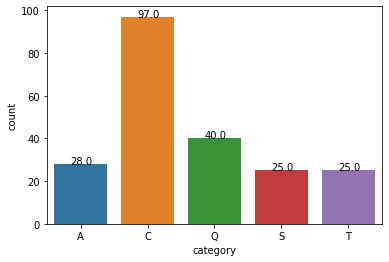

In [49]:
plot_count_graph()

### Balancing Category

In [50]:
df_list = []
for category in category_list:
    df_list.append(data.query(f"category == '{category}'").sample(n=25))

data = clean_data(data= pd.concat(df_list))

c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


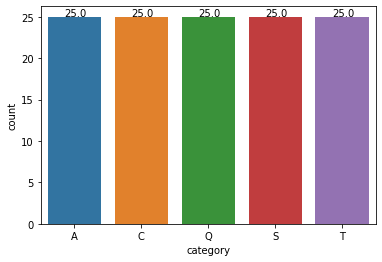

In [51]:
plot_count_graph()

In [52]:
data['message_length'] = data['message'].str.len()
print(data['message_length'])

0      177
1       35
2       12
3       35
4       39
      ... 
120    123
121     30
122     15
123    202
124    420
Name: message_length, Length: 125, dtype: int64


### Words Distribution Plot

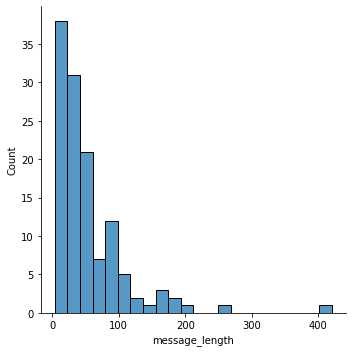

In [53]:
sns.displot(data['message_length']).set_titles('message_length')

### Count Words

In [55]:
def count_words(category=''):
    word_list = set()
    if(category != ''):
        sub_frame = data[data['category']==category]
    else:
        sub_frame = data

    for text in sub_frame['message']:
        
        text = text.lower().replace('\n', ' ').replace('\r', '').strip()
        text = re.findall(r"[\u0E00-\u0E7Fa-zA-Z']+", text)
        text = ' '.join(text)

        word_tokens = THAI2FIT_TOKENIZER.word_tokenize(text)
        filtered_sentence = set([w for w in word_tokens])

        word_list.update(filtered_sentence)

    return len(word_list)

In [56]:
words_category = []
for category in category_list:
    words_category.append(count_words(category))

words_category

[47, 243, 147, 139, 200]

In [57]:
print('Total Word:')
print(count_words())

Total Word:
474


<AxesSubplot:xlabel='category', ylabel='words_count'>

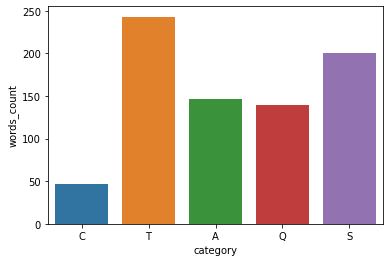

In [58]:
words_count = {'category': category_list, 'words_count': words_category}
w_count_data = pd.DataFrame(words_count)
sns.barplot(x= 'category', y='words_count', data=w_count_data)

### Word Cloud

In [59]:
def create_wordcloud(words):
    wordcloud = WordCloud(font_path='THSarabun.ttf', # path ที่ตั้ง Font
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+" # ป้องกัน bug วรรณยุกต์
                      ).generate(' '.join(THAI2FIT_TOKENIZER.word_tokenize(words)))
    plt.figure(figsize=[10, 7])
    plt.imshow(wordcloud, interpolation= "bilinear")
    plt.axis('off')
    plt.show()

In [60]:
def check_wordcloud(category):
    subset = data[data.category==category]
    text = subset.message.values
    words = ''.join(text)
    create_wordcloud(words)

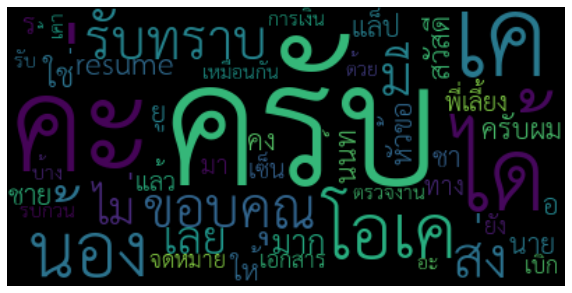

In [133]:
check_wordcloud('C')

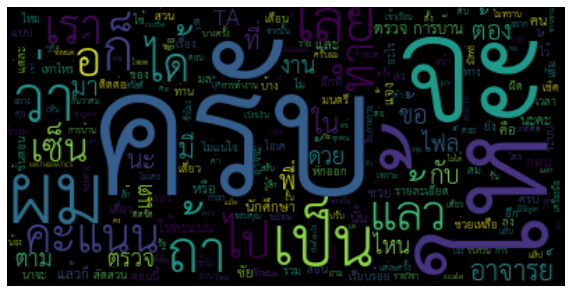

In [61]:
check_wordcloud('T')

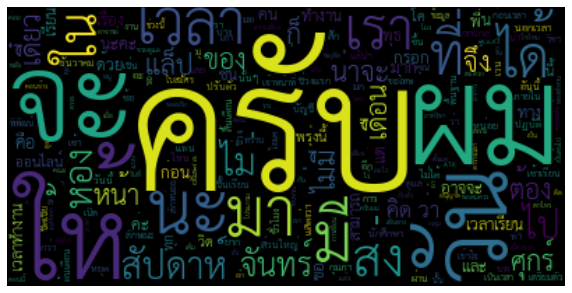

In [62]:
check_wordcloud('S')

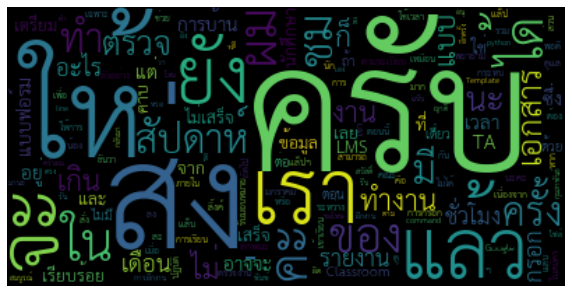

In [63]:
check_wordcloud('A')

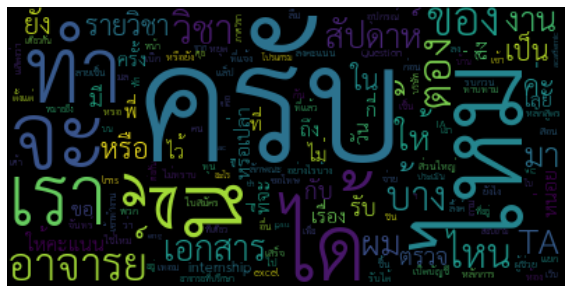

In [64]:
check_wordcloud('Q')

### Label Encoding

In [65]:
label_encoder = preprocessing.LabelEncoder()
data['category_target'] = label_encoder.fit_transform(data['category'])

In [66]:
temp_data = data[['category', 'category_target']].drop_duplicates()
print(temp_data)

    category  category_target
0          A                0
25         C                1
50         Q                2
75         S                3
100        T                4


In [67]:
# keep category target in json
json_classes = temp_data.to_json(orient="records")

# Writing to .json
with open("classes.json", "w") as outfile:
    outfile.write(json_classes)


   


In [68]:
# Opening JSON file
with open('classes.json', 'r') as openfile:
    # Reading from json file
    temp_json = json.load(openfile)
    print(temp_json)

[{'category': 'A', 'category_target': 0}, {'category': 'C', 'category_target': 1}, {'category': 'Q', 'category_target': 2}, {'category': 'S', 'category_target': 3}, {'category': 'T', 'category_target': 4}]


In [69]:
temp_json.sort(key=lambda item : item['category_target'])
print(temp_json)

[{'category': 'A', 'category_target': 0}, {'category': 'C', 'category_target': 1}, {'category': 'Q', 'category_target': 2}, {'category': 'S', 'category_target': 3}, {'category': 'T', 'category_target': 4}]


In [70]:
classes_list = [ item['category'] for item in temp_json]
print(classes_list)

['A', 'C', 'Q', 'S', 'T']


### Word2Vec

In [71]:
w2v_thai = WordVector()

In [72]:

word2vec = [w2v_thai.sentence_vectorizer(data['message'][i]) 
            for i in range(0,len(data['message']))]

In [73]:
X = np.array(word2vec).tolist()

data['word2vec'] = X
data_reshape = np.reshape(X, (-1, 300))

In [74]:
print(data_reshape.shape)

(125, 300)


In [75]:
data.head()

,message,category,message_length,category_target,word2vec
0,ซึ่ง ตามระเบียบของคณะฯ เขาให้เราทำงานไม่เกิน 6...,A,177,0,"[[-0.05435819602904043, -0.11104842913170744, ..."
1,มีตัวอย่างการกรอก อยู่ ในเอกสาร ค่ะ,A,35,0,"[[0.035409398237243296, -0.032057801634073256,..."
2,แบบฟอร์ม ค่ะ,A,12,0,"[[-0.006399000063538551, -0.013539666309952736..."
3,งาน ก็มี ช่วยดูระหว่างน้องลงแลบ ค่ะ,A,35,0,"[[-0.03348169126547873, -0.09583638465175262, ..."
4,แบบรายงานTAเดือนมกราคมเรียบร้อยแล้วครับ,A,39,0,"[[-0.33942337764892727, -0.3062093777116388, 0..."


# AI MODEL

### Split the data in Training and Testing

In [76]:
data_temp = [ x for x in data['word2vec']]
data_reshape = np.reshape(data_temp, (-1, 300))
data_reshape.shape


(125, 300)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(data_reshape,
                                                    data['category_target'],
                                                    random_state=18,
                                                    test_size = 0.2,
                                                    shuffle=True
                                                    )

In [78]:
print(X_train.shape)
print(y_train.shape)

(100, 300)
(100,)


In [79]:
print(X_test.shape)
print(y_test.shape)

(25, 300)
(25,)


### Models Predictions

In [80]:
# LinerRegression Model
l_model = LogisticRegression()
l_model.fit(X_train, y_train)
model_predictions = l_model.predict(X_test)
print('Accuracy', accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

Accuracy 0.52
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       1.00      0.50      0.67         6
           2       1.00      0.40      0.57         5
           3       0.50      0.60      0.55         5
           4       0.40      0.67      0.50         6

    accuracy                           0.52        25
   macro avg       0.63      0.50      0.51        25
weighted avg       0.67      0.52      0.54        25



In [81]:
# Unsupervised Model
kn_model = KNeighborsClassifier()
kn_model.fit(X_train, y_train)
model_predictions = kn_model.predict(X_test)
print('Accuracy', accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

Accuracy 0.4
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       1.00      0.50      0.67         6
           2       0.33      0.20      0.25         5
           3       0.40      0.40      0.40         5
           4       0.30      0.50      0.37         6

    accuracy                           0.40        25
   macro avg       0.46      0.39      0.40        25
weighted avg       0.49      0.40      0.41        25



In [118]:
# RandomForest Model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
model_predictions = rf_model.predict(X_test)
print('Accuracy', accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

Accuracy 0.6
              precision    recall  f1-score   support

           0       0.22      0.67      0.33         3
           1       1.00      0.50      0.67         6
           2       0.80      0.80      0.80         5
           3       1.00      0.60      0.75         5
           4       0.60      0.50      0.55         6

    accuracy                           0.60        25
   macro avg       0.72      0.61      0.62        25
weighted avg       0.77      0.60      0.64        25



In [107]:
# GaussianNB Model
g_model = GaussianNB()
g_model.fit(X_train, y_train)
model_predictions = g_model.predict(X_test)
print('Accuracy', accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

Accuracy 0.64
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.80      0.67      0.73         6
           2       0.80      0.80      0.80         5
           3       0.60      0.60      0.60         5
           4       0.62      0.83      0.71         6

    accuracy                           0.64        25
   macro avg       0.57      0.58      0.57        25
weighted avg       0.62      0.64      0.63        25



### Save AI Model

In [119]:
dump(l_model, './models/l_model.joblib')

['./models/l_model.joblib']

In [85]:
dump(kn_model, './models/kn_model.joblib')

['./models/kn_model.joblib']

In [120]:
dump(rf_model, './models/rf_model.joblib')

['./models/rf_model.joblib']

In [87]:
dump(g_model, './models/g_model.joblib')

['./models/g_model.joblib']

### BayesSearch Hyperparameter Tunning

In [88]:
# model = KNeighborsClassifier()
# opt = BayesSearchCV(
#     model,
#     {
#         'n_neighbors': Integer(1, 20),
#         'p': Integer(1, 20)
#     }
#     , cv=3, verbose=1, n_jobs=1
# )
# opt.fit(X_train, y_train)
# print(opt.best_score_)
# print(opt.best_params_)

In [89]:
# plot_objective(opt.optimizer_results_[0],
#                    dimensions=['n_neighbors','p'],
#                    n_minimum_search=int(1e8))
# plt.show()

# Use Case

In [121]:
# load w2vector model and ai model
model = load('./models/rf_model.joblib') 
w2v_thai = WordVector()

In [122]:
text_input = 'มีงานต้องส่งไหม'

In [123]:
test_vec = w2v_thai.sentence_vectorizer(text_input)
test_vec.shape

(1, 300)

In [124]:
output = model.predict(test_vec)
output_classes = label_encoder.classes_
output_label = output_classes[output[0]]
output_label

'A'

# Use Case with Modules


In [125]:
from project_module.message_classifier import MessageClassifier
message_classifier = MessageClassifier()

In [126]:
message_classifier.load_model(model_path='./models/l_model.joblib', json_classes_path='./classes.json')

In [135]:
print(message_classifier.classify(text_input='รับทราบครับ'))

C
